# **Evaluation of YOLO Model**

### Import libraries

In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, matthews_corrcoef, roc_auc_score
)

### Valutazione del modello CON preprocessing delle immagini

In questo codice utilizzerò 2 diverse metriche di valutazione: 
- IoU: misura quanto bene si sovrappongono le bounding box predette con quelle reali (ground truth).
- Fppi: indica quanti falsi positivi (errori di rilevamento) ci sono in media per ogni immagine.

In [13]:
# CONFIGURA PERCORSI
IMAGE_DIR = r'dataset_holdout\test\images'
LABEL_DIR = r'dataset_holdout\test\labels'
MODEL_PATH = "BestYOLO_MIAS_Final.pt"
IOU_THRESHOLD = 0.5
CONF_THRESHOLD = 0.25  # puoi modificarla

# Carica modello
model = YOLO(MODEL_PATH)

# Funzioni
def yolo_to_bbox(yolo_box, img_shape):
    x_c, y_c, w, h = yolo_box
    h_img, w_img = img_shape
    x_c *= w_img
    y_c *= h_img
    w *= w_img
    h *= h_img
    x1 = int(x_c - w / 2)
    y1 = int(y_c - h / 2)
    x2 = int(x_c + w / 2)
    y2 = int(y_c + h / 2)
    return [x1, y1, x2, y2]

def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = area1 + area2 - inter_area
    return inter_area / union_area if union_area != 0 else 0

# Inizializza metriche
iou_scores = []
fppi_counter = []

# Loop sulle immagini
for image_name in tqdm(os.listdir(IMAGE_DIR)):
    if not image_name.endswith('.png'):
        continue

    image_path = os.path.join(IMAGE_DIR, image_name)
    label_path = os.path.join(LABEL_DIR, image_name.replace('.png', '.txt'))
    image = cv2.imread(image_path)
    if image is None:
        continue

    # Ground Truth
    gt_bboxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                cls, x, y, w, h = map(float, line.strip().split())
                gt_bboxes.append(yolo_to_bbox([x, y, w, h], image.shape[:2]))

    # Predizioni
    results = model(image, conf=CONF_THRESHOLD)[0]
    boxes = results.boxes.xyxy.cpu().numpy().astype(int) if results.boxes else np.array([])
    pred_bboxes = boxes.tolist() if len(boxes) > 0 else []

    # Matching pred-GT
    matched_gt = set()
    fp = 0
    for pred_box in pred_bboxes:
        match_found = False
        for i, gt_box in enumerate(gt_bboxes):
            if i in matched_gt:
                continue
            iou = compute_iou(pred_box, gt_box)
            if iou >= IOU_THRESHOLD:
                iou_scores.append(iou)
                matched_gt.add(i)
                match_found = True
                break
        if not match_found:
            fp += 1

    fppi_counter.append(fp)

# RISULTATI
iou_mean = np.mean(iou_scores) if iou_scores else 0
fppi = np.mean(fppi_counter)

print("\n📊 RISULTATI RIDOTTI:")
print(f"IoU medio: {iou_mean:.3f}")
print(f"Falsi Positivi per Immagine (FPPI): {fppi:.3f}")


  0%|          | 0/127 [00:00<?, ?it/s]


0: 640x640 1 ANORM, 442.7ms
Speed: 10.8ms preprocess, 442.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 1/127 [00:00<01:30,  1.39it/s]


0: 640x640 (no detections), 325.8ms
Speed: 9.3ms preprocess, 325.8ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 2/127 [00:01<01:03,  1.96it/s]


0: 640x640 1 ANORM, 408.1ms
Speed: 7.8ms preprocess, 408.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 3/127 [00:01<00:59,  2.07it/s]


0: 640x640 1 ANORM, 327.4ms
Speed: 9.2ms preprocess, 327.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 4/127 [00:01<00:53,  2.29it/s]


0: 640x640 1 ANORM, 399.5ms
Speed: 7.2ms preprocess, 399.5ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 5/127 [00:02<00:53,  2.29it/s]


0: 640x640 (no detections), 316.7ms
Speed: 10.1ms preprocess, 316.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 6/127 [00:02<00:49,  2.45it/s]


0: 640x640 1 ANORM, 301.0ms
Speed: 7.7ms preprocess, 301.0ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 7/127 [00:03<00:46,  2.59it/s]


0: 640x640 1 ANORM, 261.6ms
Speed: 6.6ms preprocess, 261.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  6%|▋         | 8/127 [00:03<00:42,  2.81it/s]


0: 640x640 1 ANORM, 253.1ms
Speed: 8.6ms preprocess, 253.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 9/127 [00:03<00:39,  2.99it/s]


0: 640x640 1 ANORM, 263.0ms
Speed: 6.3ms preprocess, 263.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 10/127 [00:03<00:37,  3.09it/s]


0: 640x640 1 ANORM, 260.5ms
Speed: 5.3ms preprocess, 260.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


  9%|▊         | 11/127 [00:04<00:36,  3.18it/s]


0: 640x640 1 ANORM, 400.2ms
Speed: 7.8ms preprocess, 400.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 12/127 [00:04<00:40,  2.85it/s]


0: 640x640 1 ANORM, 314.8ms
Speed: 9.0ms preprocess, 314.8ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 13/127 [00:04<00:40,  2.83it/s]


0: 640x640 1 ANORM, 268.3ms
Speed: 6.6ms preprocess, 268.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 14/127 [00:05<00:38,  2.96it/s]


0: 640x640 1 ANORM, 263.0ms
Speed: 6.9ms preprocess, 263.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 15/127 [00:05<00:36,  3.07it/s]


0: 640x640 (no detections), 258.5ms
Speed: 5.1ms preprocess, 258.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 16/127 [00:05<00:34,  3.19it/s]


0: 640x640 (no detections), 287.0ms
Speed: 7.4ms preprocess, 287.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 17/127 [00:06<00:34,  3.17it/s]


0: 640x640 (no detections), 259.8ms
Speed: 6.4ms preprocess, 259.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 18/127 [00:06<00:33,  3.24it/s]


0: 640x640 (no detections), 281.4ms
Speed: 7.1ms preprocess, 281.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 19/127 [00:06<00:33,  3.24it/s]


0: 640x640 (no detections), 255.7ms
Speed: 6.4ms preprocess, 255.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 20/127 [00:07<00:32,  3.32it/s]


0: 640x640 1 ANORM, 259.3ms
Speed: 7.8ms preprocess, 259.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 21/127 [00:07<00:31,  3.35it/s]


0: 640x640 1 ANORM, 603.6ms
Speed: 6.6ms preprocess, 603.6ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 22/127 [00:08<00:42,  2.50it/s]


0: 640x640 (no detections), 266.9ms
Speed: 5.3ms preprocess, 266.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 23/127 [00:08<00:38,  2.71it/s]


0: 640x640 1 ANORM, 287.6ms
Speed: 6.3ms preprocess, 287.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 24/127 [00:08<00:36,  2.83it/s]


0: 640x640 1 ANORM, 283.7ms
Speed: 7.0ms preprocess, 283.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 25/127 [00:08<00:34,  2.93it/s]


0: 640x640 1 ANORM, 282.2ms
Speed: 6.8ms preprocess, 282.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 26/127 [00:09<00:33,  3.00it/s]


0: 640x640 (no detections), 280.8ms
Speed: 10.5ms preprocess, 280.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 21%|██▏       | 27/127 [00:09<00:32,  3.05it/s]


0: 640x640 1 ANORM, 275.8ms
Speed: 6.9ms preprocess, 275.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 28/127 [00:09<00:31,  3.10it/s]


0: 640x640 (no detections), 311.5ms
Speed: 7.6ms preprocess, 311.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 29/127 [00:10<00:32,  3.04it/s]


0: 640x640 (no detections), 280.9ms
Speed: 7.2ms preprocess, 280.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▎       | 30/127 [00:10<00:31,  3.09it/s]


0: 640x640 1 ANORM, 278.4ms
Speed: 7.4ms preprocess, 278.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 31/127 [00:10<00:31,  3.10it/s]


0: 640x640 (no detections), 418.5ms
Speed: 6.0ms preprocess, 418.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 32/127 [00:11<00:34,  2.76it/s]


0: 640x640 1 ANORM, 282.3ms
Speed: 5.7ms preprocess, 282.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 33/127 [00:11<00:32,  2.87it/s]


0: 640x640 (no detections), 360.1ms
Speed: 6.3ms preprocess, 360.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 34/127 [00:12<00:33,  2.77it/s]


0: 640x640 1 ANORM, 288.9ms
Speed: 8.3ms preprocess, 288.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 35/127 [00:12<00:32,  2.85it/s]


0: 640x640 1 ANORM, 284.9ms
Speed: 5.9ms preprocess, 284.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 36/127 [00:12<00:31,  2.93it/s]


0: 640x640 1 ANORM, 283.8ms
Speed: 12.5ms preprocess, 283.8ms inference, 7.7ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 37/127 [00:12<00:30,  2.95it/s]


0: 640x640 (no detections), 353.6ms
Speed: 16.4ms preprocess, 353.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 38/127 [00:13<00:31,  2.81it/s]


0: 640x640 (no detections), 292.6ms
Speed: 7.1ms preprocess, 292.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 39/127 [00:13<00:30,  2.89it/s]


0: 640x640 1 ANORM, 283.6ms
Speed: 8.1ms preprocess, 283.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 31%|███▏      | 40/127 [00:14<00:29,  2.95it/s]


0: 640x640 (no detections), 344.6ms
Speed: 5.7ms preprocess, 344.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 41/127 [00:14<00:30,  2.84it/s]


0: 640x640 (no detections), 324.7ms
Speed: 6.8ms preprocess, 324.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 42/127 [00:14<00:30,  2.82it/s]


0: 640x640 (no detections), 333.8ms
Speed: 8.3ms preprocess, 333.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 43/127 [00:15<00:30,  2.79it/s]


0: 640x640 (no detections), 508.0ms
Speed: 7.6ms preprocess, 508.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 44/127 [00:15<00:34,  2.42it/s]


0: 640x640 1 ANORM, 348.5ms
Speed: 7.3ms preprocess, 348.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 45/127 [00:16<00:33,  2.47it/s]


0: 640x640 1 ANORM, 363.5ms
Speed: 5.4ms preprocess, 363.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 46/127 [00:16<00:32,  2.49it/s]


0: 640x640 (no detections), 277.9ms
Speed: 6.9ms preprocess, 277.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 47/127 [00:16<00:30,  2.66it/s]


0: 640x640 (no detections), 309.8ms
Speed: 7.1ms preprocess, 309.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 48/127 [00:17<00:28,  2.73it/s]


0: 640x640 (no detections), 293.2ms
Speed: 5.6ms preprocess, 293.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▊      | 49/127 [00:17<00:27,  2.83it/s]


0: 640x640 1 ANORM, 277.5ms
Speed: 5.3ms preprocess, 277.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 50/127 [00:17<00:26,  2.92it/s]


0: 640x640 (no detections), 286.5ms
Speed: 7.1ms preprocess, 286.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 51/127 [00:18<00:25,  2.99it/s]


0: 640x640 1 ANORM, 356.0ms
Speed: 6.7ms preprocess, 356.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 52/127 [00:18<00:26,  2.85it/s]


0: 640x640 1 ANORM, 363.5ms
Speed: 9.4ms preprocess, 363.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 53/127 [00:18<00:27,  2.72it/s]


0: 640x640 (no detections), 267.5ms
Speed: 8.0ms preprocess, 267.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 54/127 [00:19<00:25,  2.87it/s]


0: 640x640 1 ANORM, 292.8ms
Speed: 8.3ms preprocess, 292.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 55/127 [00:19<00:24,  2.91it/s]


0: 640x640 (no detections), 313.1ms
Speed: 8.6ms preprocess, 313.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 56/127 [00:19<00:24,  2.90it/s]


0: 640x640 (no detections), 346.6ms
Speed: 4.9ms preprocess, 346.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 57/127 [00:20<00:24,  2.82it/s]


0: 640x640 (no detections), 275.7ms
Speed: 7.1ms preprocess, 275.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 58/127 [00:20<00:23,  2.94it/s]


0: 640x640 (no detections), 272.2ms
Speed: 4.9ms preprocess, 272.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▋     | 59/127 [00:20<00:22,  3.05it/s]


0: 640x640 1 ANORM, 371.9ms
Speed: 4.6ms preprocess, 371.9ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 60/127 [00:21<00:23,  2.85it/s]


0: 640x640 (no detections), 336.0ms
Speed: 9.6ms preprocess, 336.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 61/127 [00:21<00:23,  2.80it/s]


0: 640x640 1 ANORM, 299.0ms
Speed: 6.1ms preprocess, 299.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 62/127 [00:21<00:22,  2.86it/s]


0: 640x640 (no detections), 344.3ms
Speed: 5.7ms preprocess, 344.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 63/127 [00:22<00:22,  2.79it/s]


0: 640x640 (no detections), 375.3ms
Speed: 19.8ms preprocess, 375.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 64/127 [00:22<00:24,  2.59it/s]


0: 640x640 (no detections), 362.5ms
Speed: 8.3ms preprocess, 362.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 65/127 [00:23<00:24,  2.51it/s]


0: 640x640 (no detections), 638.3ms
Speed: 6.6ms preprocess, 638.3ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 66/127 [00:23<00:29,  2.08it/s]


0: 640x640 1 ANORM, 460.4ms
Speed: 7.6ms preprocess, 460.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 67/127 [00:24<00:29,  2.06it/s]


0: 640x640 1 ANORM, 318.6ms
Speed: 7.1ms preprocess, 318.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▎    | 68/127 [00:24<00:26,  2.24it/s]


0: 640x640 1 ANORM, 406.4ms
Speed: 6.0ms preprocess, 406.4ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 69/127 [00:25<00:25,  2.24it/s]


0: 640x640 1 ANORM, 290.6ms
Speed: 7.5ms preprocess, 290.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 70/127 [00:25<00:23,  2.44it/s]


0: 640x640 (no detections), 405.6ms
Speed: 6.2ms preprocess, 405.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 71/127 [00:25<00:23,  2.39it/s]


0: 640x640 (no detections), 391.2ms
Speed: 9.2ms preprocess, 391.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 72/127 [00:26<00:23,  2.37it/s]


0: 640x640 (no detections), 350.0ms
Speed: 12.5ms preprocess, 350.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 73/127 [00:26<00:22,  2.42it/s]


0: 640x640 1 ANORM, 354.4ms
Speed: 14.8ms preprocess, 354.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 74/127 [00:27<00:21,  2.45it/s]


0: 640x640 (no detections), 534.7ms
Speed: 7.5ms preprocess, 534.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 75/127 [00:27<00:23,  2.19it/s]


0: 640x640 (no detections), 376.0ms
Speed: 6.8ms preprocess, 376.0ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 76/127 [00:28<00:22,  2.26it/s]


0: 640x640 (no detections), 336.3ms
Speed: 8.4ms preprocess, 336.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 77/127 [00:28<00:21,  2.37it/s]


0: 640x640 (no detections), 369.1ms
Speed: 6.2ms preprocess, 369.1ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████▏   | 78/127 [00:28<00:20,  2.39it/s]


0: 640x640 (no detections), 721.9ms
Speed: 8.5ms preprocess, 721.9ms inference, 8.8ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 79/127 [00:29<00:25,  1.91it/s]


0: 640x640 (no detections), 425.7ms
Speed: 7.3ms preprocess, 425.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 80/127 [00:30<00:23,  1.98it/s]


0: 640x640 (no detections), 438.0ms
Speed: 6.7ms preprocess, 438.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 81/127 [00:30<00:22,  2.02it/s]


0: 640x640 1 ANORM, 411.2ms
Speed: 9.1ms preprocess, 411.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 82/127 [00:31<00:21,  2.07it/s]


0: 640x640 1 ANORM, 421.4ms
Speed: 6.3ms preprocess, 421.4ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 83/127 [00:31<00:20,  2.10it/s]


0: 640x640 1 ANORM, 342.1ms
Speed: 9.1ms preprocess, 342.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 84/127 [00:31<00:19,  2.24it/s]


0: 640x640 1 ANORM, 395.0ms
Speed: 5.2ms preprocess, 395.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 85/127 [00:32<00:18,  2.26it/s]


0: 640x640 2 ANORMs, 602.1ms
Speed: 8.9ms preprocess, 602.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 86/127 [00:33<00:20,  1.99it/s]


0: 640x640 1 ANORM, 300.3ms
Speed: 9.0ms preprocess, 300.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▊   | 87/127 [00:33<00:18,  2.21it/s]


0: 640x640 (no detections), 318.0ms
Speed: 7.2ms preprocess, 318.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 88/127 [00:33<00:16,  2.37it/s]


0: 640x640 1 ANORM, 408.0ms
Speed: 11.6ms preprocess, 408.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 89/127 [00:34<00:16,  2.33it/s]


0: 640x640 (no detections), 352.7ms
Speed: 6.6ms preprocess, 352.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 90/127 [00:34<00:15,  2.39it/s]


0: 640x640 1 ANORM, 592.1ms
Speed: 10.6ms preprocess, 592.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 91/127 [00:35<00:17,  2.07it/s]


0: 640x640 1 ANORM, 319.3ms
Speed: 9.8ms preprocess, 319.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 92/127 [00:35<00:15,  2.24it/s]


0: 640x640 (no detections), 301.8ms
Speed: 8.0ms preprocess, 301.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 93/127 [00:35<00:14,  2.43it/s]


0: 640x640 (no detections), 297.1ms
Speed: 6.8ms preprocess, 297.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 94/127 [00:36<00:12,  2.59it/s]


0: 640x640 1 ANORM, 428.4ms
Speed: 8.0ms preprocess, 428.4ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 95/127 [00:36<00:13,  2.44it/s]


0: 640x640 1 ANORM, 307.8ms
Speed: 9.3ms preprocess, 307.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 96/127 [00:36<00:12,  2.56it/s]


0: 640x640 1 ANORM, 512.2ms
Speed: 6.6ms preprocess, 512.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▋  | 97/127 [00:37<00:13,  2.28it/s]


0: 640x640 (no detections), 322.5ms
Speed: 12.4ms preprocess, 322.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 98/127 [00:37<00:12,  2.40it/s]


0: 640x640 3 ANORMs, 402.4ms
Speed: 7.4ms preprocess, 402.4ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 99/127 [00:38<00:11,  2.36it/s]


0: 640x640 2 ANORMs, 334.0ms
Speed: 7.9ms preprocess, 334.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▊  | 100/127 [00:38<00:10,  2.46it/s]


0: 640x640 (no detections), 389.5ms
Speed: 12.5ms preprocess, 389.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 101/127 [00:39<00:10,  2.42it/s]


0: 640x640 1 ANORM, 513.5ms
Speed: 8.7ms preprocess, 513.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 102/127 [00:39<00:11,  2.19it/s]


0: 640x640 (no detections), 380.0ms
Speed: 5.9ms preprocess, 380.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 103/127 [00:40<00:10,  2.26it/s]


0: 640x640 (no detections), 406.8ms
Speed: 33.6ms preprocess, 406.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 104/127 [00:40<00:10,  2.21it/s]


0: 640x640 1 ANORM, 313.4ms
Speed: 5.3ms preprocess, 313.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 105/127 [00:40<00:09,  2.38it/s]


0: 640x640 (no detections), 317.3ms
Speed: 6.2ms preprocess, 317.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 106/127 [00:41<00:08,  2.51it/s]


0: 640x640 1 ANORM, 314.2ms
Speed: 6.6ms preprocess, 314.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 107/127 [00:41<00:07,  2.60it/s]


0: 640x640 1 ANORM, 346.4ms
Speed: 6.8ms preprocess, 346.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 108/127 [00:41<00:07,  2.62it/s]


0: 640x640 (no detections), 495.0ms
Speed: 7.8ms preprocess, 495.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 109/127 [00:42<00:07,  2.35it/s]


0: 640x640 (no detections), 307.8ms
Speed: 6.3ms preprocess, 307.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 110/127 [00:42<00:06,  2.50it/s]


0: 640x640 (no detections), 359.7ms
Speed: 6.9ms preprocess, 359.7ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 111/127 [00:43<00:06,  2.51it/s]


0: 640x640 (no detections), 330.6ms
Speed: 5.4ms preprocess, 330.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 112/127 [00:43<00:05,  2.58it/s]


0: 640x640 (no detections), 361.6ms
Speed: 5.8ms preprocess, 361.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 113/127 [00:44<00:05,  2.56it/s]


0: 640x640 (no detections), 396.6ms
Speed: 8.0ms preprocess, 396.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 114/127 [00:44<00:05,  2.49it/s]


0: 640x640 (no detections), 389.7ms
Speed: 6.4ms preprocess, 389.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 115/127 [00:44<00:04,  2.43it/s]


0: 640x640 (no detections), 425.5ms
Speed: 10.7ms preprocess, 425.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████▏| 116/127 [00:45<00:04,  2.34it/s]


0: 640x640 (no detections), 782.0ms
Speed: 8.1ms preprocess, 782.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 117/127 [00:46<00:05,  1.84it/s]


0: 640x640 (no detections), 393.0ms
Speed: 11.3ms preprocess, 393.0ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 118/127 [00:46<00:04,  1.96it/s]


0: 640x640 (no detections), 284.0ms
Speed: 9.6ms preprocess, 284.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▎| 119/127 [00:46<00:03,  2.21it/s]


0: 640x640 (no detections), 261.4ms
Speed: 7.4ms preprocess, 261.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 120/127 [00:47<00:02,  2.47it/s]


0: 640x640 (no detections), 276.7ms
Speed: 7.0ms preprocess, 276.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 121/127 [00:47<00:02,  2.66it/s]


0: 640x640 (no detections), 263.3ms
Speed: 6.8ms preprocess, 263.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 122/127 [00:47<00:01,  2.85it/s]


0: 640x640 (no detections), 257.4ms
Speed: 6.2ms preprocess, 257.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 123/127 [00:48<00:01,  3.02it/s]


0: 640x640 1 ANORM, 295.0ms
Speed: 6.1ms preprocess, 295.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 124/127 [00:48<00:00,  3.04it/s]


0: 640x640 (no detections), 268.8ms
Speed: 7.2ms preprocess, 268.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 125/127 [00:48<00:00,  3.13it/s]


0: 640x640 (no detections), 409.7ms
Speed: 7.6ms preprocess, 409.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 126/127 [00:49<00:00,  2.80it/s]


0: 640x640 (no detections), 258.5ms
Speed: 7.1ms preprocess, 258.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


100%|██████████| 127/127 [00:49<00:00,  2.57it/s]


📊 RISULTATI RIDOTTI:
IoU medio: 0.877
Falsi Positivi per Immagine (FPPI): 0.008


## Test sull'efficienza complessiva del modello (Senza applicare la ROI)

⚙️ Esecuzione preprocessing...
✅ Preprocessing completato in 0.5039 secondi

🚀 Caricamento modello YOLO...
✅ Modello caricato in 0.6337 secondi

🔍 Esecuzione inferenza...

0: 640x640 2 ANORMs, 659.1ms
Speed: 29.6ms preprocess, 659.1ms inference, 23.9ms postprocess per image at shape (1, 3, 640, 640)
✅ Inferenza completata in 1.3767 secondi
📦 Bounding box rilevate: 2

⏱️ TEMPO TOTALE: 2.5143 secondi
  - Preprocessing: 0.5039s (20.0%)
  - Caricamento modello: 0.6337s (25.2%)
  - Inferenza: 1.3767s (54.8%)


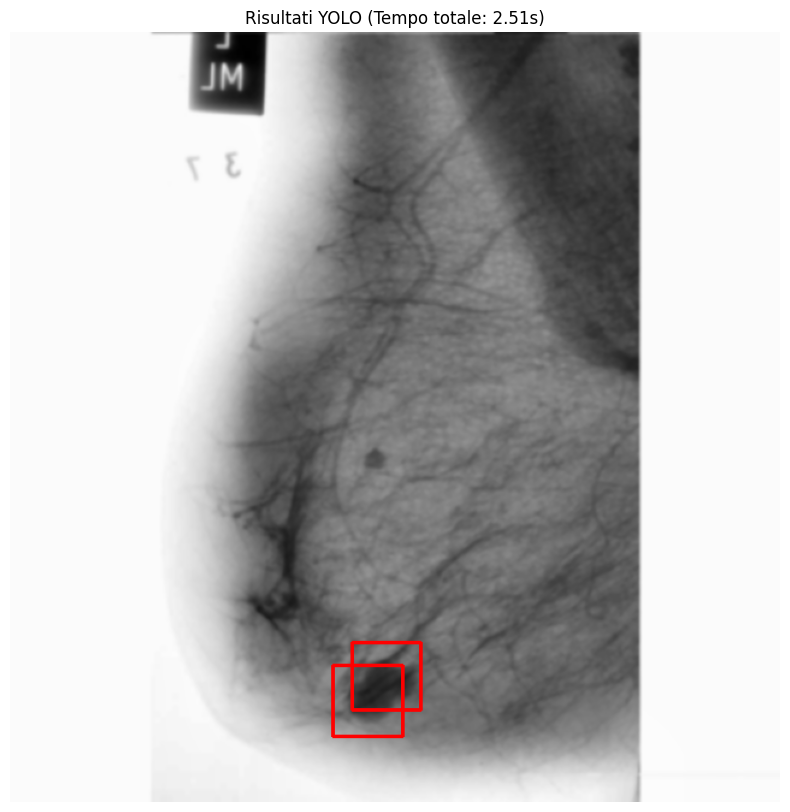

In [14]:
import cv2
import numpy as np
import time
import os
import pandas as pd
import tensorflow as tf
from ultralytics import YOLO
from tqdm import tqdm
import matplotlib.pyplot as plt

def preprocess_for_yolo(image_path):
    """Preprocessing specifico per YOLO con misurazione del tempo"""
    start_time = time.time()
    
    # Step 1: Caricamento e resize
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Impossibile caricare l'immagine: {image_path}")
    
    original = image.copy()
    width, height = 640, 640
    image = cv2.resize(image, (width, height))
    resized = image.copy()
    
    # Step 2: Applica filtro Gaussiano
    image = cv2.GaussianBlur(image, (5, 5), 0)
    blurred = image.copy()
    
    # Step 3: Inversione dei colori
    image = tf.math.subtract(tf.reduce_max(image), image)
    image = image.numpy()
    inverted = image.copy()
    
    preprocessing_time = time.time() - start_time
    
    # Visualizzazione (opzionale)
    if False:  # Impostare a True per visualizzare i passaggi
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Originale')
        axes[1].imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
        axes[1].set_title('Ridimensionata')
        axes[2].imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
        axes[2].set_title('Sfocata')
        axes[3].imshow(cv2.cvtColor(inverted, cv2.COLOR_BGR2RGB))
        axes[3].set_title('Invertita')
        plt.show()
    
    return image, preprocessing_time

def run_yolo_inference(model, image):
    """Esegue inferenza YOLO con misurazione del tempo"""
    start_time = time.time()
    results = model(image, conf=0.25)[0]  # Soglia di confidenza predefinita
    inference_time = time.time() - start_time
    
    # Estrae le bounding box
    boxes = results.boxes.xyxy.cpu().numpy().astype(int) if results.boxes else np.array([])
    
    return boxes, inference_time

# Configurazione percorsi
IMAGE_PATH = "mdb005.jpg"  # Sostituire con il percorso dell'immagine
MODEL_PATH = "BestYOLO_MIAS_Final.pt"  # Sostituire con il percorso del modello

# 1. Preprocessing
print("⚙️ Esecuzione preprocessing...")
preprocessed_img, prep_time = preprocess_for_yolo(IMAGE_PATH)
print(f"✅ Preprocessing completato in {prep_time:.4f} secondi")

# 2. Caricamento modello
print("\n🚀 Caricamento modello YOLO...")
model_load_start = time.time()
model = YOLO(MODEL_PATH)
model_load_time = time.time() - model_load_start
print(f"✅ Modello caricato in {model_load_time:.4f} secondi")

# 3. Inferenza
print("\n🔍 Esecuzione inferenza...")
boxes, infer_time = run_yolo_inference(model, preprocessed_img)
print(f"✅ Inferenza completata in {infer_time:.4f} secondi")
print(f"📦 Bounding box rilevate: {len(boxes)}")

# 4. Tempi totali
total_time = prep_time + model_load_time + infer_time
print(f"\n⏱️ TEMPO TOTALE: {total_time:.4f} secondi")
print(f"  - Preprocessing: {prep_time:.4f}s ({prep_time/total_time*100:.1f}%)")
print(f"  - Caricamento modello: {model_load_time:.4f}s ({model_load_time/total_time*100:.1f}%)")
print(f"  - Inferenza: {infer_time:.4f}s ({infer_time/total_time*100:.1f}%)")

# 5. Visualizzazione risultati (opzionale)
if len(boxes) > 0:
    result_img = cv2.cvtColor(preprocessed_img, cv2.COLOR_BGR2RGB)
    for box in boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(result_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(result_img)
    plt.axis('off')
    plt.title(f"Risultati YOLO (Tempo totale: {total_time:.2f}s)")
    plt.show()

### Con l'applicazione della ROI

⚙️ Esecuzione preprocessing YOLO...
✅ Preprocessing completato in 0.0258 secondi

🚀 Caricamento modello YOLO...
✅ Modello caricato in 0.3434 secondi

🔍 Esecuzione inferenza YOLO...

0: 640x640 2 ANORMs, 360.8ms
Speed: 11.4ms preprocess, 360.8ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)
✅ Inferenza completata in 0.5959 secondi
📦 Bounding box rilevate: 2

🔄 Elaborazione mammografia e aggiustamento bounding box...


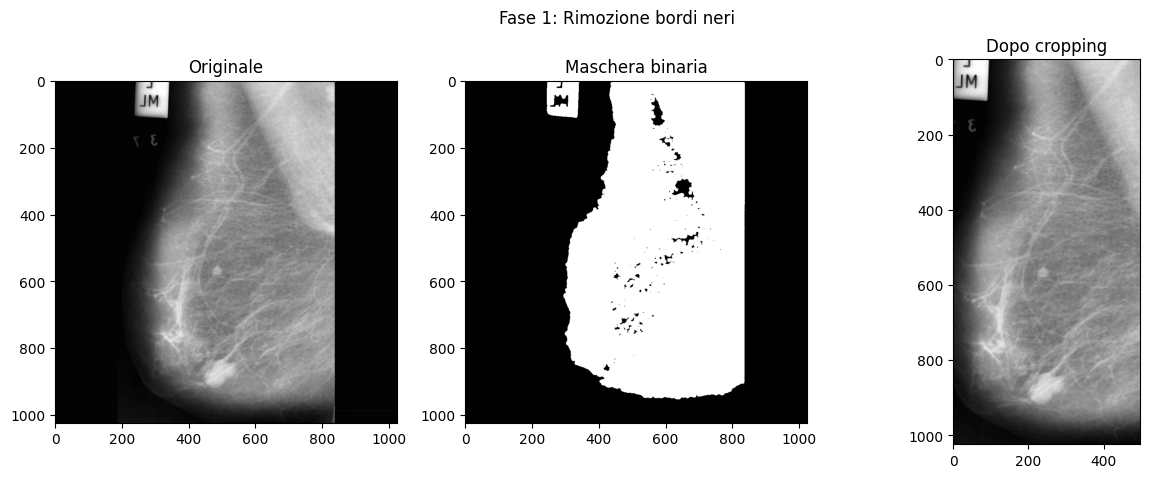

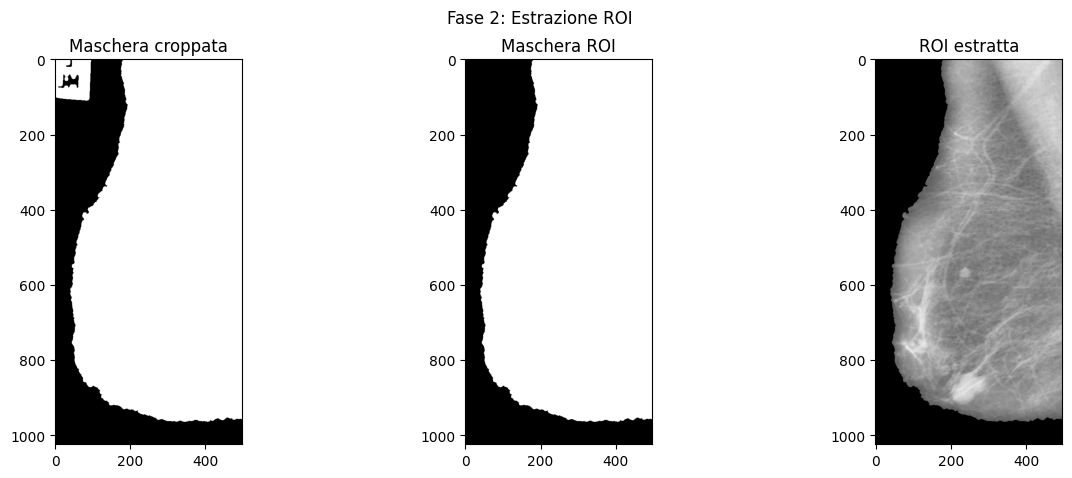

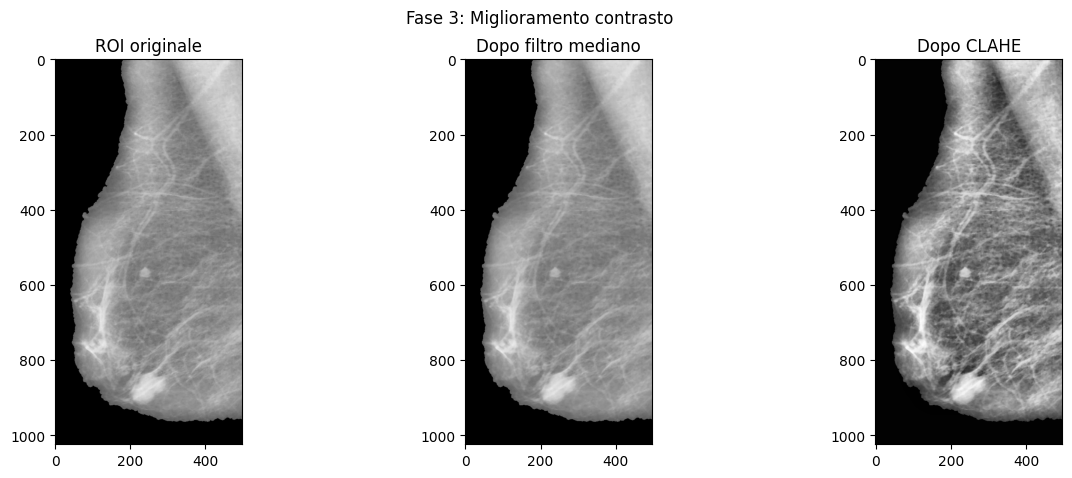

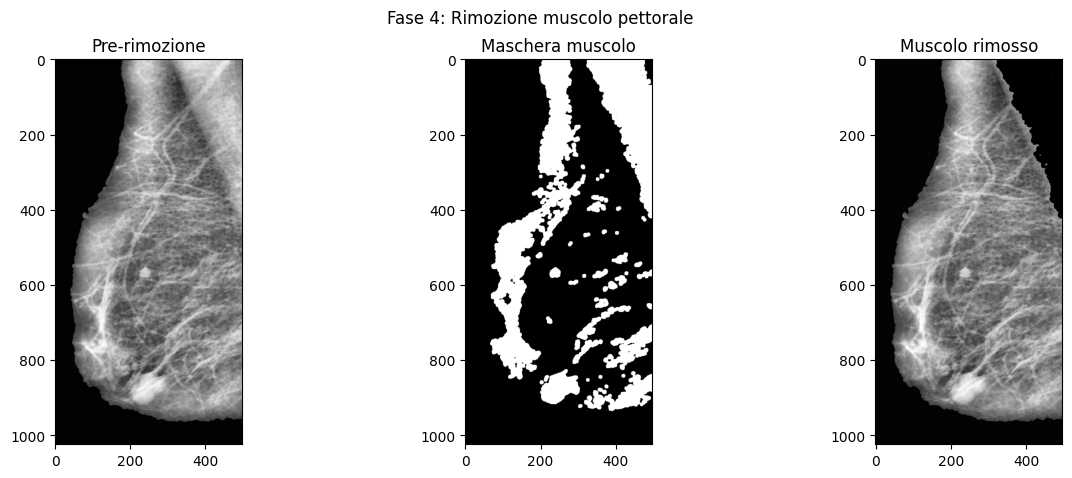

🔄 Bounding box aggiustate per cropping: L=246, R=742


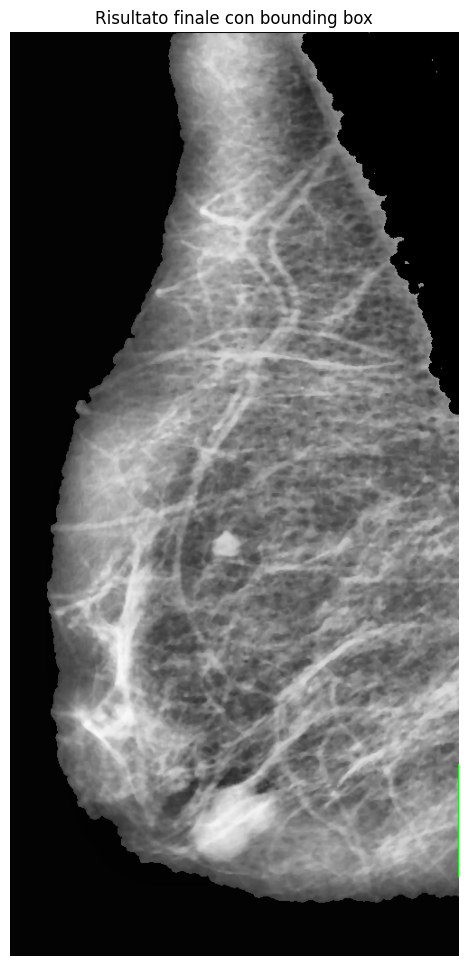


💾 Risultato salvato come 'risultato_finale.jpg'

⏱️ TEMPO TOTALE: 0.9650 secondi
  - Preprocessing YOLO: 0.0258s (2.7%)
  - Caricamento modello: 0.3434s (35.6%)
  - Inferenza YOLO: 0.5959s (61.7%)


In [7]:
import cv2
import numpy as np
import time
import os
import pandas as pd
import tensorflow as tf
from ultralytics import YOLO
from tqdm import tqdm
from skimage.morphology import disk, binary_opening
from skimage.measure import label, regionprops
from skimage.filters import threshold_multiotsu
import matplotlib.pyplot as plt

def preprocess_for_yolo(image_path):
    """Preprocessing specifico per YOLO con misurazione del tempo"""
    start_time = time.time()
    
    # Step 1: Caricamento e resize
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Impossibile caricare l'immagine: {image_path}")
    
    original = image.copy()
    width, height = 640, 640
    image = cv2.resize(image, (width, height))
    
    # Step 2: Applica filtro Gaussiano
    image = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Step 3: Inversione dei colori
    image = tf.math.subtract(tf.reduce_max(image), image)
    image = image.numpy()
    
    preprocessing_time = time.time() - start_time
    
    return original, image, preprocessing_time

def run_yolo_inference(model, image):
    """Esegue inferenza YOLO con misurazione del tempo"""
    start_time = time.time()
    results = model(image, conf=0.25)[0]
    inference_time = time.time() - start_time
    
    # Estrae le bounding box in formato normalizzato
    boxes = results.boxes.xywhn.cpu().numpy() if results.boxes else np.array([])
    
    return boxes, inference_time

def adjust_boxes_for_cropping(boxes, W_old, L, R):
    """Aggiusta le bounding box dopo il cropping orizzontale"""
    W_new = W_old - L - R
    
    adjusted_boxes = []
    for box in boxes:
        cx, cy, w, h = box
        
        # Denormalizzazione e correzione coordinate
        cx_abs = cx * W_old
        cx_new = (cx_abs - L) / W_new
        
        # Correzione larghezza
        w_new = w * W_old / W_new
        
        # Aggiornamento bounding box
        adjusted_boxes.append([cx_new, cy, w_new, h])
    
    return np.array(adjusted_boxes)

def preprocess_mammogram(img_color):
    """Preprocessing completo con visualizzazione dei plot"""
    # Converti in scala di grigi
    img_original = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    
    # 1. Rimozione bordi neri
    img_double = img_original.astype(np.float64) / 255.0
    img_squared = (img_double * img_original).astype(np.uint8)
    
    _, binary_initial = cv2.threshold(img_squared, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    footprint = disk(5)
    binary_opened = binary_opening(binary_initial, footprint=footprint).astype(np.uint8) * 255
    
    first_row = binary_opened[0, :]
    left_crop = np.argmax(first_row > 0)
    right_crop = len(first_row) - np.argmax(first_row[::-1] > 0) - 1
    img_cropped = img_original[:, left_crop:right_crop+1]
    
    # Visualizzazione passo 1
    plt.figure(figsize=(15, 5))
    plt.subplot(131), plt.imshow(img_original, cmap='gray'), plt.title('Originale')
    plt.subplot(132), plt.imshow(binary_opened, cmap='gray'), plt.title('Maschera binaria')
    plt.subplot(133), plt.imshow(img_cropped, cmap='gray'), plt.title('Dopo cropping')
    plt.suptitle('Fase 1: Rimozione bordi neri')
    plt.show()
    
    # 2. Estrazione ROI
    _, binary_cropped = cv2.threshold(img_cropped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_cropped_opened = binary_opening(binary_cropped, footprint=footprint).astype(np.uint8) * 255
    
    labeled_img = label(binary_cropped_opened)
    regions = regionprops(labeled_img)
    
    if not regions:
        raise ValueError("Nessuna regione trovata nell'immagine binarizzata croppata.")
    
    largest_region = max(regions, key=lambda x: x.area)
    mask = np.zeros_like(binary_cropped_opened, dtype=np.uint8)
    minr, minc, maxr, maxc = largest_region.bbox
    mask[minr:maxr, minc:maxc] = (labeled_img[minr:maxr, minc:maxc] == largest_region.label).astype(np.uint8) * 255
    roi_extracted_img = cv2.bitwise_and(img_cropped, img_cropped, mask=mask)
    
    # Visualizzazione passo 2
    plt.figure(figsize=(15, 5))
    plt.subplot(131), plt.imshow(binary_cropped_opened, cmap='gray'), plt.title('Maschera croppata')
    plt.subplot(132), plt.imshow(mask, cmap='gray'), plt.title('Maschera ROI')
    plt.subplot(133), plt.imshow(roi_extracted_img, cmap='gray'), plt.title('ROI estratta')
    plt.suptitle('Fase 2: Estrazione ROI')
    plt.show()
    
    # 3. Miglioramento contrasto
    median_filtered = cv2.medianBlur(roi_extracted_img, 3)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_enhanced = clahe.apply(median_filtered)
    
    # Visualizzazione passo 3
    plt.figure(figsize=(15, 5))
    plt.subplot(131), plt.imshow(roi_extracted_img, cmap='gray'), plt.title('ROI originale')
    plt.subplot(132), plt.imshow(median_filtered, cmap='gray'), plt.title('Dopo filtro mediano')
    plt.subplot(133), plt.imshow(contrast_enhanced, cmap='gray'), plt.title('Dopo CLAHE')
    plt.suptitle('Fase 3: Miglioramento contrasto')
    plt.show()
    
    # 4. Rimozione muscolo pettorale
    thresholds = threshold_multiotsu(contrast_enhanced, classes=3)
    segmented = np.digitize(contrast_enhanced, bins=thresholds)
    bright_mask = (segmented == 2).astype(np.uint8) * 255
    footprint = disk(5)
    bright_mask_cleaned = binary_opening(bright_mask, footprint=footprint).astype(np.uint8) * 255
    
    labeled = label(bright_mask_cleaned)
    regions = regionprops(labeled)
    muscle_removed = contrast_enhanced.copy()
    h, w = contrast_enhanced.shape
    
    for region in regions:
        minr, minc, maxr, maxc = region.bbox
        in_upper_right = minr < h // 3 and minc > w // 2
        if region.area > 500 and in_upper_right:
            muscle_mask = (labeled == region.label).astype(np.uint8)
            extended_mask = muscle_mask.copy()
            visited = np.zeros_like(muscle_mask, dtype=bool)
            stack = [(0, w - 1)]
            
            while stack:
                r, c = stack.pop()
                if not (0 <= r < h and 0 <= c < w) or visited[r, c]:
                    continue
                visited[r, c] = True
                
                if muscle_mask[r, c] == 1:
                    continue
                    
                extended_mask[r, c] = 1
                neighbors = [(r - 1, c), (r + 1, c), (r, c - 1), (r, c + 1)]
                for nr, nc in neighbors:
                    if 0 <= nr < h and 0 <= nc < w and not visited[nr, nc]:
                        stack.append((nr, nc))
            
            muscle_removed[extended_mask == 1] = 0
            break
    
    # Visualizzazione passo 4
    plt.figure(figsize=(15, 5))
    plt.subplot(131), plt.imshow(contrast_enhanced, cmap='gray'), plt.title('Pre-rimozione')
    plt.subplot(132), plt.imshow(bright_mask_cleaned, cmap='gray'), plt.title('Maschera muscolo')
    plt.subplot(133), plt.imshow(muscle_removed, cmap='gray'), plt.title('Muscolo rimosso')
    plt.suptitle('Fase 4: Rimozione muscolo pettorale')
    plt.show()
    
    return muscle_removed, left_crop, right_crop

# Configurazione percorsi
IMAGE_PATH = "mdb005.jpg"
MODEL_PATH = "BestYOLO_MIAS_Final.pt"

# 1. Preprocessing per YOLO
print("⚙️ Esecuzione preprocessing YOLO...")
original_img, preprocessed_img, prep_time = preprocess_for_yolo(IMAGE_PATH)
print(f"✅ Preprocessing completato in {prep_time:.4f} secondi")

# 2. Caricamento modello
print("\n🚀 Caricamento modello YOLO...")
model_load_start = time.time()
model = YOLO(MODEL_PATH)
model_load_time = time.time() - model_load_start
print(f"✅ Modello caricato in {model_load_time:.4f} secondi")

# 3. Inferenza YOLO
print("\n🔍 Esecuzione inferenza YOLO...")
boxes, infer_time = run_yolo_inference(model, preprocessed_img)
print(f"✅ Inferenza completata in {infer_time:.4f} secondi")
print(f"📦 Bounding box rilevate: {len(boxes)}")

# 4. Preprocessing mammografia e aggiustamento bounding box
print("\n🔄 Elaborazione mammografia e aggiustamento bounding box...")
W_old = original_img.shape[1]
final_img, L, R = preprocess_mammogram(original_img)

if boxes.size > 0:
    adjusted_boxes = adjust_boxes_for_cropping(boxes, W_old, L, R)
    print(f"🔄 Bounding box aggiustate per cropping: L={L}, R={R}")

# 5. Visualizzazione risultati finali
result_img = cv2.cvtColor(final_img, cv2.COLOR_GRAY2BGR) if len(final_img.shape) == 2 else final_img.copy()

if boxes.size > 0:
    H, W = final_img.shape[:2]
    for box in adjusted_boxes:
        cx, cy, w, h = box
        # Converti da normalizzato a pixel
        x_center = int(cx * W)
        y_center = int(cy * H)
        box_width = int(w * W)
        box_height = int(h * H)
        
        # Calcola coordinate angolo
        x1 = max(0, x_center - box_width // 2)
        y1 = max(0, y_center - box_height // 2)
        x2 = min(W, x_center + box_width // 2)
        y2 = min(H, y_center + box_height // 2)
        
        # Disegna bounding box
        cv2.rectangle(result_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Visualizzazione finale
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title('Risultato finale con bounding box')
plt.axis('off')
plt.show()

# Salvataggio risultati
cv2.imwrite("risultato_finale.jpg", result_img)
print("\n💾 Risultato salvato come 'risultato_finale.jpg'")

# 6. Tempi totali
total_time = prep_time + model_load_time + infer_time
print(f"\n⏱️ TEMPO TOTALE: {total_time:.4f} secondi")
print(f"  - Preprocessing YOLO: {prep_time:.4f}s ({prep_time/total_time*100:.1f}%)")
print(f"  - Caricamento modello: {model_load_time:.4f}s ({model_load_time/total_time*100:.1f}%)")
print(f"  - Inferenza YOLO: {infer_time:.4f}s ({infer_time/total_time*100:.1f}%)")